In [1]:
%pip install -U keras-segmentation opencv-python
import keras_segmentation as ks

Requirement already up-to-date: keras-segmentation in /opt/anaconda3/lib/python3.7/site-packages (0.2.0)
Requirement already up-to-date: opencv-python in /opt/anaconda3/lib/python3.7/site-packages (4.1.2.30)
Note: you may need to restart the kernel to use updated packages.


Using TensorFlow backend.


In [2]:
#model = ks.models.unet.vgg_unet(n_classes=2, input_height=400, input_width=400) #TODO: try to use builtin model with cropped images
from keras.models import *
from keras.layers import *
n_classes = 2
input_width = 400
input_height = input_width

img_input = Input(shape=(input_height, input_width, 3))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

out = Conv2D(n_classes, (1, 1), padding='same')(conv5)

from keras_segmentation.models.model_utils import get_segmentation_model

model = get_segmentation_model(img_input ,  out) # this would build the segmentation model





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [3]:
# data has been splitted manually between train and validation sets
import sys
IN_COLAB = 'google.colab' in sys.modules
if (IN_COLAB):
    from google.colab import drive
    drive.mount('/content/gdrive')
    PATH_OF_DATA= '/content/gdrive/"My Drive"/Documents/EPFL/ML_Project_2/data'
else:
    PATH_OF_DATA= './data'
IMAGES_SUFFIX='images'
GD_SUFFIX='groundtruth'
TRAIN_PREFIX='train'
VALIDATION_PREFIX='val'
PREPPED='prepped'
!ls {PATH_OF_DATA}

train_groundtruth         val_images                vgg_unet_1.44
train_images              val_prepped_groundtruth   vgg_unet_1.51
train_prepped_groundtruth val_prepped_images        vgg_unet_1_config.json
train_prepped_images      vgg_unet_1.10
val_groundtruth           vgg_unet_1.20


In [4]:
EPOCH_TO_LOAD='51'
model.load_weights(f'{PATH_OF_DATA}/vgg_unet_1.{EPOCH_TO_LOAD}')

In [5]:
import os
from helpers import *

PREPPED_PREFIX = 'prepped'
def prepped_path(path, suffix=None):
    if suffix is None:
        path = prepped_path(path, GD_SUFFIX)
        path = prepped_path(path, IMAGES_SUFFIX)
        return path
    return path.replace(suffix, f'{PREPPED_PREFIX}_{suffix}')

# Loaded a set of images
TRAIN_IMG=0
VAL_IMG=1
TRAIN_GD=2
VAL_GD=3
SETS = [TRAIN_IMG, VAL_IMG, TRAIN_GD, VAL_GD]

PATHS = [None]*len(SETS)
PATHS[TRAIN_IMG] = f'{PATH_OF_DATA}/{TRAIN_PREFIX}_{PREPPED_PREFIX}_{IMAGES_SUFFIX}/'
PATHS[VAL_IMG] = f'{PATH_OF_DATA}/{VALIDATION_PREFIX}_{PREPPED_PREFIX}_{IMAGES_SUFFIX}/'
PATHS[TRAIN_GD] = f'{PATH_OF_DATA}/{TRAIN_PREFIX}_{PREPPED_PREFIX}_{GD_SUFFIX}/'
PATHS[VAL_GD] = f'{PATH_OF_DATA}/{VALIDATION_PREFIX}_{PREPPED_PREFIX}_{GD_SUFFIX}/'

# Clean .DS_store to avoid troubles listing images
for label in SETS:
    for path in [PATHS[label], prepped_path(PATHS[label])]:
        !rm -f {path}.DS_store

# Load images
imgs = [None]*len(SETS)
for label in SETS:
    files = os.listdir(PATHS[label])
    imgs[label] = [load_image(PATHS[label] + files[i]) for i in range(len(files))]
    
# Convert groundtruth between 0 and 1
GD = [TRAIN_GD, VAL_GD]
for label in GD:
    for i, img in enumerate(imgs[label]):
        #imgs[label][i] = img_float_to_uint8(img)
        imgs[label][i][img>0] = 1.
        
print(imgs[TRAIN_GD][0][imgs[TRAIN_GD][0]!=0])

[1 1 1 ... 1 1 1]


0.8625375


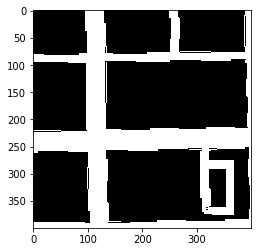

In [6]:
IMG_ID=1
plt.imshow(imgs[TRAIN_GD][IMG_ID]*255)
print(np.count_nonzero(imgs[TRAIN_GD][IMG_ID])/(400*400))

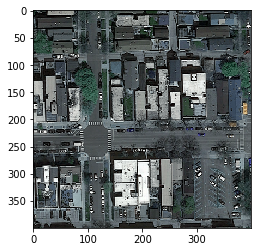

In [7]:
plt.imshow(imgs[TRAIN_IMG][IMG_ID])

In [8]:
predicted = model.predict(np.array([imgs[TRAIN_IMG][IMG_ID]]))
print(predicted.shape)

(1, 160000, 2)


In [9]:
pp = np.zeros((400,400))
print(pp.shape)
for i in range(160000):
    val = predicted[0,i][0]
    pp[i%400,int(i/400)] = 1. if val > 0.5 else 0

(400, 400)


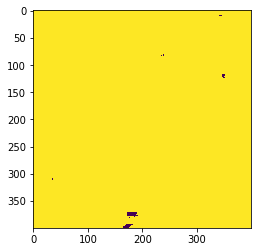

In [10]:
plt.imshow(pp*255)